In [1]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu118
  Using cached https://download.pytorch.org/whl/cu118/torch-2.3.0%2Bcu118-cp310-cp310-linux_x86_64.whl (839.6 MB)
  Using cached https://download.pytorch.org/whl/cu118/torchvision-0.18.0%2Bcu118-cp310-cp310-linux_x86_64.whl (6.3 MB)
  Using cached https://download.pytorch.org/whl/cu118/torchaudio-2.3.0%2Bcu118-cp310-cp310-linux_x86_64.whl (3.3 MB)
  Using cached https://download.pytorch.org/whl/cu118/nvidia_cudnn_cu11-8.7.0.84-py3-none-manylinux1_x86_64.whl (728.5 MB)
  Using cached https://download.pytorch.org/whl/cu118/nvidia_cusolver_cu11-11.4.1.48-py3-none-manylinux1_x86_64.whl (128.2 MB)
  Using cached https://download.pytorch.org/whl/triton-2.3.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (168.1 MB)
  Using cached https://download.pytorch.org/whl/Jinja2-3.1.3-py3-none-any.whl (133 kB)

[notice] A new release of pip is available: 

## Data Preprocess

In [28]:
import glob 
import os
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

In [29]:
# Paths
path = 'data3'

imglist = glob.glob(path+'/*.gz')

# Test Data Set Number
include_numbers = ['316', '318', '319', '320']

imglist_test = [path for path in imglist if any(num in os.path.basename(path) for num in include_numbers)]
imglist_train = [path for path in imglist if path not in imglist_test]

print('num_train = {}, num_test = {}'.format(len(imglist_train), len(imglist_test)))

num_train = 37, num_test = 4


In [91]:
class MRIDataset(Dataset):
    def __init__(self, image_path_list, mask = None):
        self.image_path_list = image_path_list
        # Define the specific range of slices to use
        self.slice_start = 80
        self.slice_end = 90
        self.slices_per_file = self.slice_end - self.slice_start
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x / torch.max(x)),  # Normalize each image to [0, 1] based on its max value
            # transforms.Lambda(lambda x: (x - x.mean()) / (x.std() + 1e-8))
        ])
        self.mask = mask

    def __len__(self):
        # Total number of slices is the number of files multiplied by the number of slices per file in the defined range
        return len(self.image_path_list) * self.slices_per_file

    def __getitem__(self, idx):
        # Determine which file and which slice within that file's specified range
        file_idx = idx // self.slices_per_file
        slice_idx = idx % self.slices_per_file + self.slice_start
        
        # Load and process the specific slice
        img_3d = nib.load(self.image_path_list[file_idx]).get_fdata()
        img_3d = img_3d.transpose(0, 2, 1)  # Adjust the dimensions as required
        img_slice = img_3d[:, :, slice_idx]
        
        # Ensure the image data type is suitable for transformation
        img_slice = self.transform(img_slice)[0]

        #fft shift onto K-space domain
        fft_data = np.fft.fft2(img_slice)
        fft_shift_data = np.fft.fftshift(fft_data)

        # Avoid complex number for kspace domain
        magnitude_spectrum = np.abs(fft_shift_data)
        log_magnitude = np.log(magnitude_spectrum + 1)

        # Undersampling
        # Apply the mask to the fft_shift_data
        if self.mask is not None:
            undersampled_fft_data = fft_shift_data * self.mask
        else:
            undersampled_fft_data = fft_shift_data
        
        # Inverse FFT shift
        ifft_shift_data = np.fft.ifftshift(undersampled_fft_data)
        
        # Inverse FFT to reconstruct the image
        reconstructed_image = np.fft.ifft2(ifft_shift_data)
        reconstructed_image = np.real(reconstructed_image) 
        
        result = {'target_image': img_slice, 'target_kspace': fft_shift_data, 
                  'under_kspace': undersampled_fft_data, 'under_image': reconstructed_image} 
        
        return result

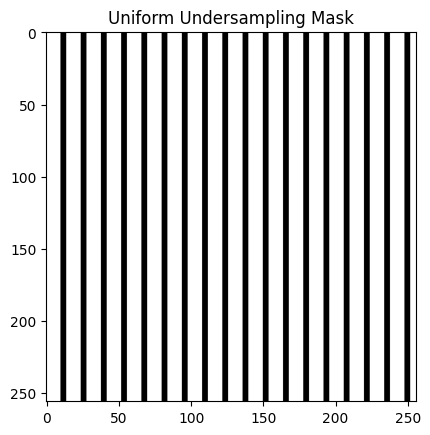

In [32]:
import numpy as np
import matplotlib.pyplot as plt

def uniform_undersampling_mask(shape, stripe_width, retained_fraction):
    mask = np.zeros(shape)
    position = 0
    full_stripe_width = stripe_width  # Fixed width for each stripe

    # Calculate the gap width based on retained fraction
    if retained_fraction == 1:
        gap_width = 0
    else:
        gap_width = int(stripe_width / retained_fraction - stripe_width)

    while position < shape[1]:
        retained_width = int(full_stripe_width)  # The actual width of retained stripes
        mask[:, int(max(0, position)):int(min(shape[1], position + retained_width))] = 1
        position += retained_width + gap_width

    return mask

# Example usage
shape = (256, 256)  # Define the shape of the image
stripe_width = 10
retained_fraction = 0.7  # Define the fraction of the image to be retained (not masked)
uniform_mask = uniform_undersampling_mask(shape, stripe_width, retained_fraction)

plt.imshow(mask, cmap='gray')
plt.title('Uniform Undersampling Mask')
plt.show()

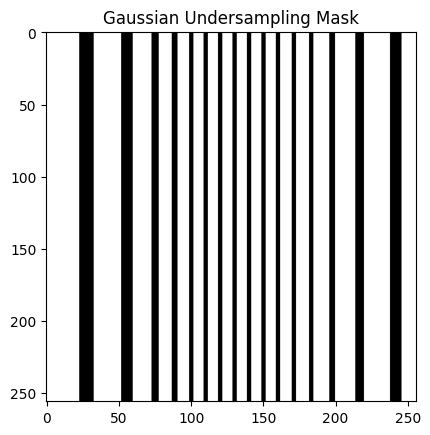

In [33]:
import numpy as np
import matplotlib.pyplot as plt

def gaussian_undersampling_mask(shape, max_stripe_width, min_stripe_width, retained_fraction):
    mask = np.zeros(shape)
    center = shape[1] // 2
    sigma = shape[1] / 6  # Standard deviation for Gaussian distribution
    x = np.linspace(-center, center, shape[1])
    widths = (max_stripe_width - min_stripe_width) * np.exp(-x**2 / (2 * sigma**2)) + min_stripe_width

    position = 0
    while position < shape[1]:
        current_width = int(widths[int(position + center) % shape[1]])
        # Scale the width of retained stripes according to the retained fraction
        retained_width = int(current_width * retained_fraction)
        mask[:, int(max(0, position)):int(min(shape[1], position + retained_width))] = 1
        # The gap is inversely proportional to the retained fraction
        gap_width = int(current_width * (1 - retained_fraction))
        position += retained_width + gap_width

    return mask

# Example usage
shape = (256,256)  # Height, width of the image
max_stripe_width = 35
min_stripe_width = 10
retained_fraction = 0.7  # 50% of the image is retained
gaussian_mask = gaussian_undersampling_mask(shape, max_stripe_width, min_stripe_width, retained_fraction)

plt.imshow(gaussian_mask, cmap='gray')
plt.title('Gaussian Undersampling Mask')
plt.show()


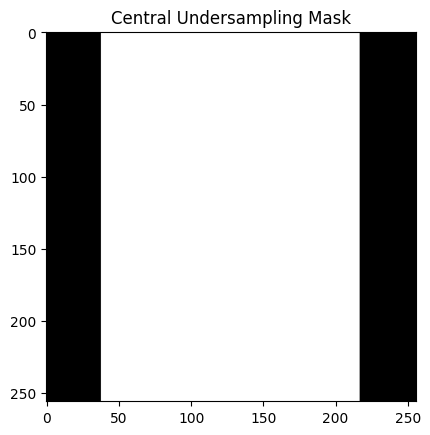

In [34]:
def central_undersampling_mask(shape, central_fraction):
    mask = np.zeros(shape)
    central_width = int(shape[1] * central_fraction)
    start = (shape[1] - central_width) // 2
    mask[:, start:start + central_width] = 1
    return mask

# Usage
central_fraction = 0.7  # Keep 50% width at the center
central_mask = central_undersampling_mask((256,256), central_fraction)
plt.imshow(central_mask, cmap='gray')
plt.title('Central Undersampling Mask')
plt.show()


## Data Load

In [35]:
uniform_dataset = MRIDataset(imglist_train, mask=uniform_mask)
gaussian_dataset = MRIDataset(imglist_train, mask=gaussian_mask)
central_dataset = MRIDataset(imglist_train, mask=central_mask)

uniform_dataloader = DataLoader(uniform_dataset, batch_size=16, shuffle=True, num_workers=4)
gaussian_dataloader = DataLoader(gaussian_dataset, batch_size=16, shuffle=True, num_workers=4)
central_dataloader = DataLoader(central_dataset, batch_size=16, shuffle=True, num_workers=4)

In [36]:
sample_result = next(iter(uniform_dataloader))

In [38]:
gaussian_sample = next(iter(gaussian_dataloader))

In [43]:
central_sample = next(iter(central_dataloader))

In [53]:
np.any(np.iscomplex(sample_result['target_image']))

False

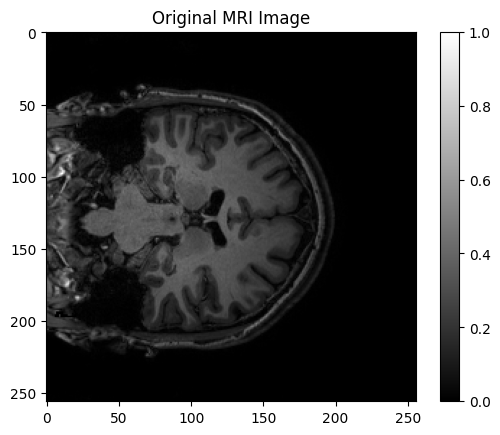

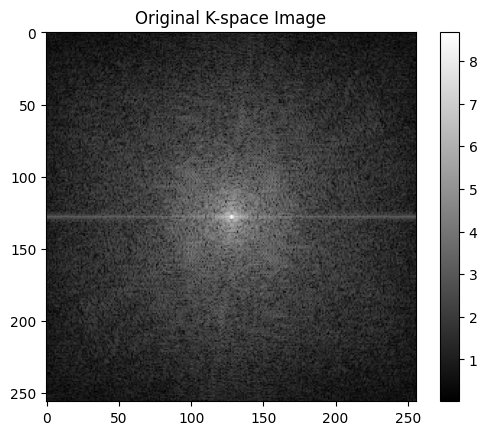

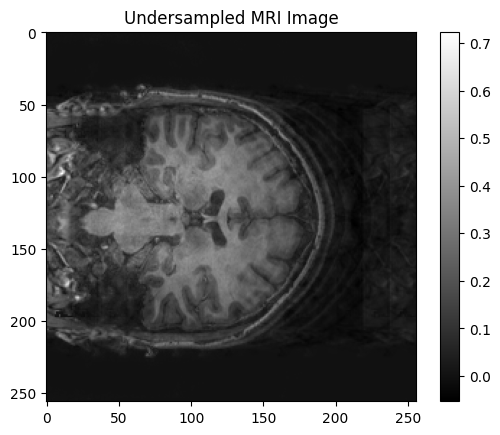

In [45]:
plt.imshow(sample_result['target_image'][0], cmap='gray')
plt.title('Original MRI Image')
plt.colorbar()
plt.show()
sample_target_kspace = sample_result['target_kspace'][0]
sample_target_kspace = np.abs(sample_target_kspace)
sample_target_kspace = np.log(sample_target_kspace + 1)
plt.imshow(sample_target_kspace, cmap='gray')
plt.title('Original K-space Image')
plt.colorbar()
plt.show()
plt.imshow(sample_result['under_image'][0], cmap='gray')
plt.title('Undersampled MRI Image')
plt.colorbar()
plt.show()

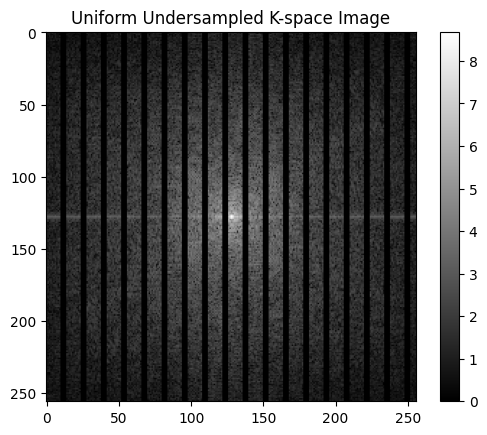

In [46]:
sample_under_kspace = sample_result['under_kspace'][0]
sample_under_kspace = np.abs(sample_under_kspace)
sample_under_kspace = np.log(sample_under_kspace + 1)


plt.imshow(sample_under_kspace, cmap='gray')
plt.title('Uniform Undersampled K-space Image')
plt.colorbar()
plt.show()

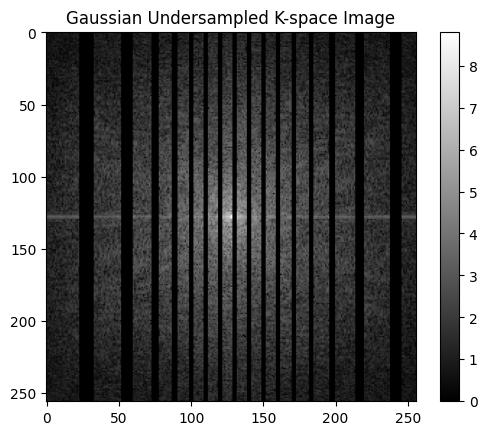

In [47]:
sample_under_kspace = gaussian_sample['under_kspace'][0]
sample_under_kspace = np.abs(sample_under_kspace)
sample_under_kspace = np.log(sample_under_kspace + 1)


plt.imshow(sample_under_kspace, cmap='gray')
plt.title('Gaussian Undersampled K-space Image')
plt.colorbar()
plt.show()

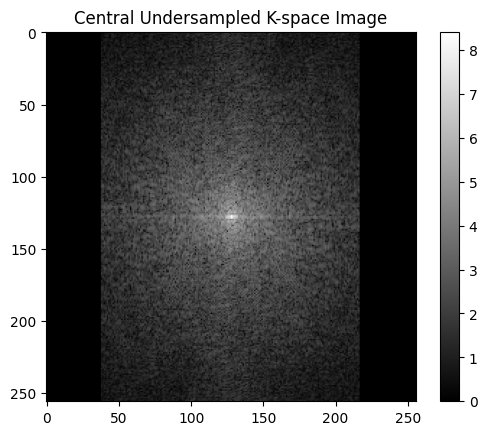

In [48]:
sample_under_kspace = central_sample['under_kspace'][0]
sample_under_kspace = np.abs(sample_under_kspace)
sample_under_kspace = np.log(sample_under_kspace + 1)


plt.imshow(sample_under_kspace, cmap='gray')
plt.title('Central Undersampled K-space Image')
plt.colorbar()
plt.show()

In [154]:
from torch.utils.data import random_split

def split_data(dataset):
    # Calculate the sizes for each dataset
    total_size = len(dataset)
    val_size = int(0.2 * total_size)  # 20% for testing
    train_size = total_size - val_size  # Remaining 80% for training + validation
    
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    return train_dataset, val_dataset 

def print_data_lengths_one_line(train, val, test, data_label):
    print(f"{data_label} - Train: {len(train)}, Val: {len(val)}, Test: {len(test)}")

def create_dataloader(train_dataset, val_dataset, test_dataset):
    # Now, create DataLoaders for each of these sets
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)

    return train_loader, val_loader, test_loader

In [155]:
uniform_dataset = MRIDataset(imglist_train, mask=uniform_mask)
gaussian_dataset = MRIDataset(imglist_train, mask=gaussian_mask)
central_dataset = MRIDataset(imglist_train, mask=central_mask)

uniform_dataset_train, uniform_dataset_val = split_data(uniform_dataset)
gaussian_dataset_train, gaussian_dataset_val = split_data(gaussian_dataset)
central_dataset_train, central_dataset_val = split_data(central_dataset)

uniform_dataset_test = MRIDataset(imglist_test, mask=uniform_mask)
gaussian_dataset_test = MRIDataset(imglist_test, mask=gaussian_mask)
central_dataset_test = MRIDataset(imglist_test, mask=central_mask)

uniform_train, uniform_val, uniform_test = create_dataloader(uniform_dataset_train, uniform_dataset_val, uniform_dataset_test)
gaussian_train, gaussian_val, gaussian_test = create_dataloader(gaussian_dataset_train, gaussian_dataset_val, gaussian_dataset_test)
central_train, central_val, central_test = create_dataloader(central_dataset_train, central_dataset_val, central_dataset_test)

In [156]:
print_data_lengths_one_line(uniform_dataset_train, uniform_dataset_val, uniform_dataset_test, "uniform undersample")

uniform undersample - Train: 296, Val: 74, Test: 40


In [157]:
uniform_dataset_train.__len__()

296

## Load Model

In [86]:
# Load the model
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
                       in_channels=3, out_channels=1, init_features=32, pretrained=True)

Using cache found in /home/elicer/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [87]:
if isinstance(model.encoder1[0], nn.Conv2d):
    # Create a new Conv2d layer with 1 input channel and the same output channels, kernel size, etc.
    new_conv = nn.Conv2d(1, model.encoder1[0].out_channels, 
                         kernel_size=model.encoder1[0].kernel_size, 
                         stride=model.encoder1[0].stride, 
                         padding=model.encoder1[0].padding, 
                         bias=(model.encoder1[0].bias is not None))

    # Replace the old conv layer with the new one
    model.encoder1[0] = new_conv

In [72]:
from collections import OrderedDict

import torch
import torch.nn as nn


class UNet(nn.Module):

    def __init__(self, in_channels=1, out_channels=1, init_features=32):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        return torch.sigmoid(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

## Train Model

### Train in Image Domain

In [119]:
import sys
def image_train_model(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=10, device='cuda'):
    model.to(device)  # Ensure the model is on the correct device
    train_loss_list = []
    val_loss_list = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        total_batches = 0

        for data in train_dataloader:
            inputs, targets = data['under_image'], data['target_image']

            inputs = inputs.unsqueeze(1).to(device)  # Add channel dimension and transfer to device
            targets = targets.unsqueeze(1).to(device)

            optimizer.zero_grad()  # Clear gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, targets)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update model parameters

            running_loss += loss.item()
            total_batches += 1
            
        average_loss = running_loss / total_batches
        train_loss_list.append(average_loss)
        # print(f'Epoch {epoch + 1}/{num_epochs}, Training Average Loss: {average_loss:.4f}')

        # Validation phase
        model.eval()
        with torch.no_grad():
            val_running_loss = 0.0
            val_total_batches = 0

            for data in val_dataloader:
                inputs, targets = data['under_image'], data['target_image']

                inputs = inputs.unsqueeze(1).to(device)
                targets = targets.unsqueeze(1).to(device)

                outputs = model(inputs)
                val_loss = criterion(outputs, targets)

                val_running_loss += val_loss.item()
                val_total_batches += 1

            val_average_loss = val_running_loss / val_total_batches
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {average_loss:.4f}, Val Loss: {val_average_loss:.4f}')
        val_loss_list.append(val_average_loss)

    print('Finished Training')
    return model, train_loss_list, val_loss_list

### Reconstructing Uniform Undersampled Image

In [120]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

image_model = UNet()
image_model = image_model.double()

image_model.to(device)
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.Adam(image_model.parameters(), lr=0.01)
uniform_model, uniform_train_loss, uniform_val_loss = image_train_model(image_model, uniform_train, uniform_val, criterion, 
                                                                        optimizer, num_epochs=10)

Epoch 1/10, Train Loss: 0.1035, Val Loss: 0.0257
Epoch 2/10, Train Loss: 0.0104, Val Loss: 0.0419
Epoch 3/10, Train Loss: 0.0028, Val Loss: 0.0121
Epoch 4/10, Train Loss: 0.0018, Val Loss: 0.0041
Epoch 5/10, Train Loss: 0.0015, Val Loss: 0.0044
Epoch 6/10, Train Loss: 0.0013, Val Loss: 0.0027
Epoch 7/10, Train Loss: 0.0012, Val Loss: 0.0029
Epoch 8/10, Train Loss: 0.0011, Val Loss: 0.0015
Epoch 9/10, Train Loss: 0.0010, Val Loss: 0.0012
Epoch 10/10, Train Loss: 0.0009, Val Loss: 0.0010
Finished Training


In [121]:
torch.save(uniform_model.state_dict(), 'uniform_image_model.pth')

### Reconstructing Gaussian Undersampled Image

In [122]:
image_model = UNet()
image_model = image_model.double()

image_model.to(device)
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.Adam(image_model.parameters(), lr=0.01)
gaussian_model, gaussian_train_loss, gaussian_val_loss = image_train_model(image_model, gaussian_train, gaussian_val, 
                                                                           criterion, optimizer, num_epochs=10)

Epoch 1/10, Train Loss: 0.1241, Val Loss: 0.8489
Epoch 2/10, Train Loss: 0.0195, Val Loss: 0.0218
Epoch 3/10, Train Loss: 0.0045, Val Loss: 0.0060
Epoch 4/10, Train Loss: 0.0028, Val Loss: 0.0041
Epoch 5/10, Train Loss: 0.0024, Val Loss: 0.0026
Epoch 6/10, Train Loss: 0.0021, Val Loss: 0.0021
Epoch 7/10, Train Loss: 0.0019, Val Loss: 0.0020
Epoch 8/10, Train Loss: 0.0017, Val Loss: 0.0021
Epoch 9/10, Train Loss: 0.0017, Val Loss: 0.0019
Epoch 10/10, Train Loss: 0.0015, Val Loss: 0.0015
Finished Training


In [123]:
torch.save(gaussian_model.state_dict(), 'gaussian_image_model.pth')

### Reconstructing Central Undersampled Image

In [124]:
image_model = UNet()
image_model = image_model.double()

image_model.to(device)
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.Adam(image_model.parameters(), lr=0.01)
central_model, central_train_loss, central_val_loss = image_train_model(image_model, central_train, central_val, 
                                                                        criterion, optimizer, num_epochs=10)

Epoch 1/10, Train Loss: 0.0965, Val Loss: 0.2198
Epoch 2/10, Train Loss: 0.0079, Val Loss: 0.0179
Epoch 3/10, Train Loss: 0.0024, Val Loss: 0.0058
Epoch 4/10, Train Loss: 0.0013, Val Loss: 0.0018
Epoch 5/10, Train Loss: 0.0009, Val Loss: 0.0012
Epoch 6/10, Train Loss: 0.0007, Val Loss: 0.0011
Epoch 7/10, Train Loss: 0.0006, Val Loss: 0.0015
Epoch 8/10, Train Loss: 0.0006, Val Loss: 0.0007
Epoch 9/10, Train Loss: 0.0005, Val Loss: 0.0006
Epoch 10/10, Train Loss: 0.0005, Val Loss: 0.0006
Finished Training


In [125]:
torch.save(central_model.state_dict(), 'central_image_model.pth')

## Train, Val Loss Graph

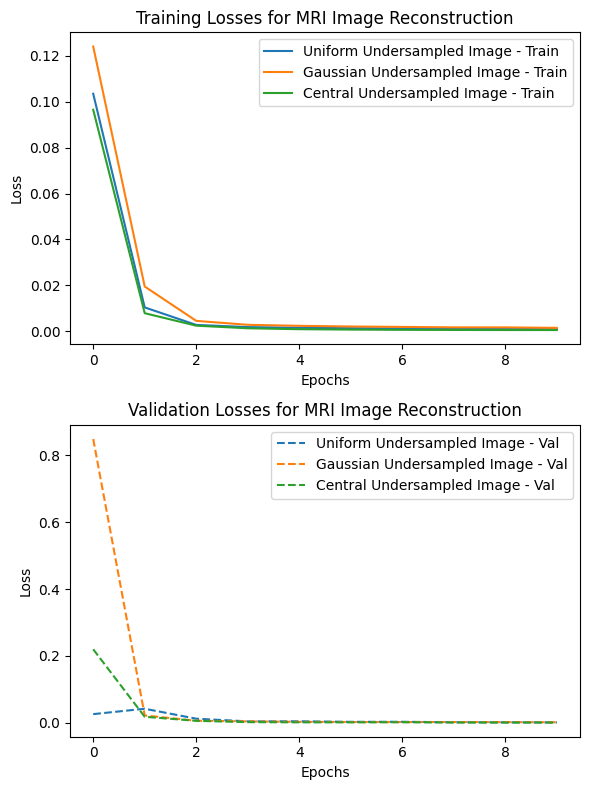

In [127]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,8))
ax1.plot(uniform_train_loss, label=f'Uniform Undersampled Image - Train')
ax2.plot(uniform_val_loss, label=f'Uniform Undersampled Image - Val', linestyle='--')

ax1.plot(gaussian_train_loss, label=f'Gaussian Undersampled Image - Train')
ax2.plot(gaussian_val_loss, label=f'Gaussian Undersampled Image - Val', linestyle='--')

ax1.plot(central_train_loss, label=f'Central Undersampled Image - Train')
ax2.plot(central_val_loss, label=f'Central Undersampled Image - Val', linestyle='--')

ax1.set_title('Training Losses for MRI Image Reconstruction')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Set titles and labels for the second subplot
ax2.set_title('Validation Losses for MRI Image Reconstruction')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [75]:
device

device(type='cuda')

### Train in K-space Domain

In [251]:
import numpy as np

def kspace_train_model(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=10, device='cuda'):
    train_loss_list = []
    val_loss_list = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        total_batches = 0

        for data in train_dataloader:
            inputs, targets = data['under_kspace'], data['target_kspace']

            # Apply preprocessing to the input and target tensors
            inputs = np.abs(inputs)
            inputs = np.log(inputs + 1)
            
            targets = np.abs(targets)
            targets = np.log(targets + 1)
            
            inputs = inputs / torch.max(inputs)
            targets = targets / torch.max(targets)

            inputs = inputs.unsqueeze(1).to(device)  # Add channel dimension and transfer to device
            targets = targets.unsqueeze(1).to(device)

            optimizer.zero_grad()  # Clear gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, targets)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update model parameters

            running_loss += loss.item()
            total_batches += 1

        average_loss = running_loss / total_batches
        train_loss_list.append(average_loss)
        # print(f'Epoch {epoch + 1}/{num_epochs}, Training Average Loss: {average_loss:.4f}')

        # Validation phase
        model.eval()
        with torch.no_grad():
            val_running_loss = 0.0
            val_total_batches = 0

            for data in val_dataloader:
                inputs, targets = data['under_kspace'], data['target_kspace']

                inputs = np.abs(inputs)
                inputs = np.log(inputs + 1)
                targets = np.abs(targets)
                targets = np.log(targets + 1)

                inputs = inputs / torch.max(inputs)
                targets = targets / torch.max(targets)

                inputs = inputs.unsqueeze(1).to(device)
                targets = targets.unsqueeze(1).to(device)

                outputs = model(inputs)
                val_loss = criterion(outputs, targets)

                val_running_loss += val_loss.item()
                val_total_batches += 1

            val_average_loss = val_running_loss / val_total_batches
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {average_loss:.4f}, Val Loss: {val_average_loss:.4f}')
        val_loss_list.append(val_average_loss)

    print('Finished Training')
    return model, train_loss_list, val_loss_list


### Train K-space with absolute value

In [252]:
kspace_model = UNet()
kspace_model = kspace_model.double()

kspace_model.to(device)
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.Adam(kspace_model.parameters(), lr=0.01)
uniform_kspace_model, uniform_kspace_train_loss, uniform_kspace_val_loss  = kspace_train_model(kspace_model, uniform_train, uniform_val, 
                                                                                               criterion, optimizer, num_epochs=20)

Epoch 1/20, Train Loss: 0.0442, Val Loss: 0.0487
Epoch 2/20, Train Loss: 0.0047, Val Loss: 0.0408
Epoch 3/20, Train Loss: 0.0032, Val Loss: 0.0286
Epoch 4/20, Train Loss: 0.0026, Val Loss: 0.0117
Epoch 5/20, Train Loss: 0.0025, Val Loss: 0.0041
Epoch 6/20, Train Loss: 0.0024, Val Loss: 0.0028
Epoch 7/20, Train Loss: 0.0024, Val Loss: 0.0026
Epoch 8/20, Train Loss: 0.0023, Val Loss: 0.0024
Epoch 9/20, Train Loss: 0.0022, Val Loss: 0.0023
Epoch 10/20, Train Loss: 0.0021, Val Loss: 0.0021
Epoch 11/20, Train Loss: 0.0020, Val Loss: 0.0020
Epoch 12/20, Train Loss: 0.0019, Val Loss: 0.0018
Epoch 13/20, Train Loss: 0.0017, Val Loss: 0.0017
Epoch 14/20, Train Loss: 0.0015, Val Loss: 0.0016
Epoch 15/20, Train Loss: 0.0014, Val Loss: 0.0014
Epoch 16/20, Train Loss: 0.0012, Val Loss: 0.0013
Epoch 17/20, Train Loss: 0.0011, Val Loss: 0.0011
Epoch 18/20, Train Loss: 0.0010, Val Loss: 0.0011
Epoch 19/20, Train Loss: 0.0010, Val Loss: 0.0010
Epoch 20/20, Train Loss: 0.0009, Val Loss: 0.0009
Finished 

In [253]:
torch.save(uniform_kspace_model.state_dict(), 'uniform_kspace_model.pth')

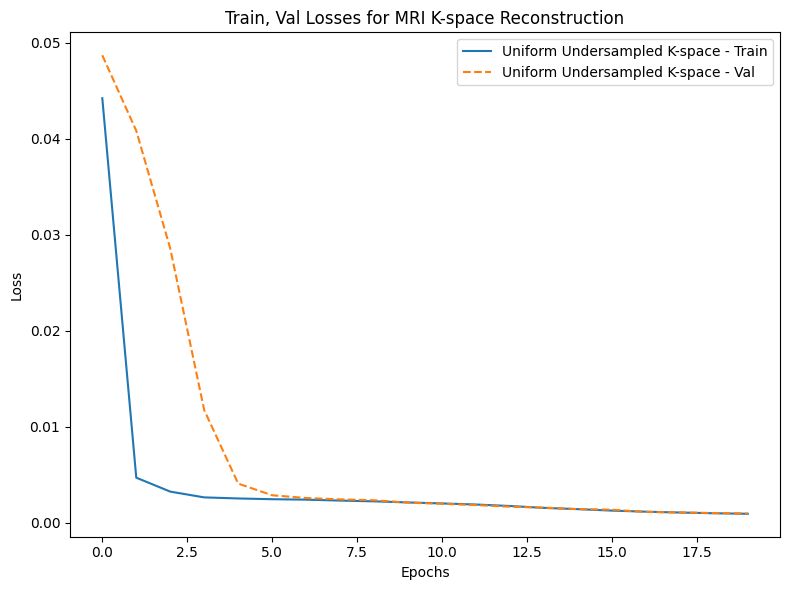

In [325]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(uniform_kspace_train_loss, label=f'Uniform Undersampled K-space - Train')
ax.plot(uniform_kspace_val_loss, label=f'Uniform Undersampled K-space - Val', linestyle='--')


ax.set_title('Train, Val Losses for MRI K-space Reconstruction')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

### Train K-space with real and imaginary value

In [318]:
import torch
import numpy as np
import sys

def kspace_train_model_with_imag(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=10, device='cuda'):
    train_loss_list = []
    val_loss_list = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        total_batches = 0

        for data in train_dataloader:
            # Extract real and imaginary parts
            inputs_real = data['under_kspace'].real
            inputs_imag = data['under_kspace'].imag
            targets_real = data['target_kspace'].real
            targets_imag = data['target_kspace'].imag

            # Stack real and imaginary parts as separate channels and ensure correct dimensions
            inputs = np.stack((inputs_real, inputs_imag), axis=1)  # This should result in shape [batch_size, 2, height, width]
            targets = np.stack((targets_real, targets_imag), axis=1)

            # Convert to tensors
            inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
            targets = torch.tensor(targets, dtype=torch.float32).to(device)

            inputs = inputs.double()
            targets = targets.double()

            inputs = inputs/torch.max(inputs)
            targets = targets/torch.max(targets)

            optimizer.zero_grad()  # Clear gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, targets)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update model parameters

            running_loss += loss.item()
            total_batches += 1

        average_loss = running_loss / total_batches
        train_loss_list.append(average_loss)

        # Validation phase
        model.eval()
        with torch.no_grad():
            val_running_loss = 0.0
            val_total_batches = 0

            for data in val_dataloader:
                # Extract real and imaginary parts
                inputs_real = data['under_kspace'].real
                inputs_imag = data['under_kspace'].imag
                targets_real = data['target_kspace'].real
                targets_imag = data['target_kspace'].imag

                # Stack real and imaginary parts as separate channels and ensure correct dimensions
                inputs = np.stack((inputs_real, inputs_imag), axis=1)  # This should result in shape [batch_size, 2, height, width]
                targets = np.stack((targets_real, targets_imag), axis=1)

                # Convert to tensors
                inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
                targets = torch.tensor(targets, dtype=torch.float32).to(device)

                inputs = inputs.double()
                targets = targets.double()

                inputs = inputs/torch.max(inputs)
                targets = targets/torch.max(targets)

                outputs = model(inputs)
                val_loss = criterion(outputs, targets)

                val_running_loss += val_loss.item()
                val_total_batches += 1

            val_average_loss = val_running_loss / val_total_batches
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {average_loss:.4f}, Val Loss: {val_average_loss:.4f}')
        val_loss_list.append(val_average_loss)

    print('Finished Training')
    return model, train_loss_list, val_loss_list


In [319]:
kspace_model = UNet(in_channels=2, out_channels=2, init_features=32)
kspace_model = kspace_model.double()

kspace_model.to(device)
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.Adam(kspace_model.parameters(), lr=0.001)
uniform_kspace_model_2, uniform_kspace_train_loss_2, uniform_kspace_val_loss_2  = kspace_train_model_with_imag(kspace_model, uniform_train, uniform_val, 
                                                                                               criterion, optimizer, num_epochs=10)

Epoch 1/10, Train Loss: 0.2244, Val Loss: 0.2263
Epoch 2/10, Train Loss: 0.1621, Val Loss: 0.1540
Epoch 3/10, Train Loss: 0.1363, Val Loss: 0.1224
Epoch 4/10, Train Loss: 0.1159, Val Loss: 0.1029
Epoch 5/10, Train Loss: 0.0979, Val Loss: 0.0862
Epoch 6/10, Train Loss: 0.0820, Val Loss: 0.0737
Epoch 7/10, Train Loss: 0.0685, Val Loss: 0.0613
Epoch 8/10, Train Loss: 0.0571, Val Loss: 0.0474
Epoch 9/10, Train Loss: 0.0477, Val Loss: 0.0384
Epoch 10/10, Train Loss: 0.0399, Val Loss: 0.0299
Finished Training


In [302]:
torch.save(uniform_kspace_model_2.state_dict(), 'uniform_kspace_model_with_imag.pth')

## Test Model

### Test Image Model

In [194]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

def test_image_model(model, test_loader, device):
    model.eval()
    mse_loss = []
    psnr_list = []
    ssim_list = []
    with torch.no_grad():
        for data in test_loader:
            inputs, targets = data['under_image'], data['target_image']

            inputs = inputs.unsqueeze(1).to(device)
            targets = targets.unsqueeze(1).to(device)
            
            outputs = model(inputs)
            mse_value = criterion(outputs, targets)
            
            inputs = inputs.detach().cpu().numpy()
            outputs = outputs.detach().cpu().numpy()
            targets = targets.detach().cpu().numpy()

            psnr_value = psnr(targets, inputs, data_range=inputs.max() - inputs.min())
            ssim_value = ssim(targets[0][0], inputs[0][0], data_range=inputs.max() - inputs.min())


            mse_loss.append(mse_value.detach().cpu().numpy())
            psnr_list.append(psnr_value)
            ssim_list.append(ssim_value)

    return np.mean(mse_loss), np.mean(psnr_list), np.mean(ssim_list)

In [200]:
image_test_mse, image_test_psnr, image_test_ssim = test_kspace_model(uniform_model, uniform_test, device)
print(f'Uniform Undersampling Image Reconstruction MSE: {image_test_mse:.4f}, PSNR: {image_test_psnr:.4f}, SSIM: {image_test_ssim:.4f}')

Uniform Undersampling Image Reconstruction MSE: 1.8871, PSNR: 18.3390, SSIM: 0.4911


In [201]:
image_test_mse, image_test_psnr, image_test_ssim = test_kspace_model(gaussian_model, gaussian_test, device)
print(f'Gaussian Undersampling Image Reconstruction MSE: {image_test_mse:.4f}, PSNR: {image_test_psnr:.4f}, SSIM: {image_test_ssim:.4f}')

Gaussian Undersampling Image Reconstruction MSE: 3.8220, PSNR: 18.2166, SSIM: 0.4998


In [202]:
image_test_mse, image_test_psnr, image_test_ssim = test_kspace_model(central_model, central_test, device)
print(f'Central Undersampling Image Reconstruction MSE: {image_test_mse:.4f}, PSNR: {image_test_psnr:.4f}, SSIM: {image_test_ssim:.4f}')

Central Undersampling Image Reconstruction MSE: 1.5309, PSNR: 21.3376, SSIM: 0.7060


### Test Kspace with absolute value Model

In [192]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

def test_kspace_model(model, test_loader, device):
    model.eval()
    mse_loss = []
    psnr_list = []
    ssim_list = []
    with torch.no_grad():
        for data in test_loader:
            inputs, targets = data['under_kspace'], data['target_kspace']

            inputs = np.abs(inputs)
            inputs = np.log(inputs + 1)
            targets = np.abs(targets)
            targets = np.log(targets + 1)

            inputs = inputs.unsqueeze(1).to(device)
            targets = targets.unsqueeze(1).to(device)
            
            outputs = model(inputs)
            mse_value = criterion(outputs, targets)
            
            inputs = inputs.detach().cpu().numpy()
            outputs = outputs.detach().cpu().numpy()
            targets = targets.detach().cpu().numpy()

            psnr_value = psnr(targets, inputs, data_range=inputs.max() - inputs.min())
            ssim_value = ssim(targets[0][0], inputs[0][0], data_range=inputs.max() - inputs.min())


            mse_loss.append(mse_value.detach().cpu().numpy())
            psnr_list.append(psnr_value)
            ssim_list.append(ssim_value)

    return np.mean(mse_loss), np.mean(psnr_list), np.mean(ssim_list)

In [304]:
kspace_test_mse, kspace_test_psnr, kspace_test_ssim = test_kspace_model(uniform_kspace_model, uniform_test, device)
print(f'Model trained with absolute k-space, MSE: {kspace_test_mse:.4f}, PSNR: {kspace_test_psnr:.4f}, SSIM: {kspace_test_ssim:.4f}')

Model trained with absolute k-space, MSE: 1.3821, PSNR: 18.3390, SSIM: 0.4911


## Test Kspace with real and imaginary value model

In [305]:
def test_kspace_model_with_imag(model, test_loader, device):
    model.eval()
    mse_loss = []
    psnr_list = []
    ssim_list = []
    with torch.no_grad():
        for data in test_loader:

            inputs_real = data['under_kspace'].real
            inputs_imag = data['under_kspace'].imag
            targets_real = data['target_kspace'].real
            targets_imag = data['target_kspace'].imag

            inputs = np.stack((inputs_real, inputs_imag), axis=1)  
            targets = np.stack((targets_real, targets_imag), axis=1)

            inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
            targets = torch.tensor(targets, dtype=torch.float32).to(device)

            inputs = inputs.double()
            targets = targets.double()

            inputs = inputs/torch.max(inputs)
            targets = targets/torch.max(targets)
            
            outputs = model(inputs)
            mse_value = criterion(outputs, targets)
            
            inputs = inputs.detach().cpu().numpy()
            outputs = outputs.detach().cpu().numpy()
            targets = targets.detach().cpu().numpy()

            psnr_value = psnr(targets, inputs, data_range=inputs.max() - inputs.min())
            ssim_value = ssim(targets[0][0], inputs[0][0], data_range=inputs.max() - inputs.min())


            mse_loss.append(mse_value.detach().cpu().numpy())
            psnr_list.append(psnr_value)
            ssim_list.append(ssim_value)

    return np.mean(mse_loss), np.mean(psnr_list), np.mean(ssim_list)

In [306]:
kspace_test_mse, kspace_test_psnr, kspace_test_ssim = test_kspace_model_with_imag(uniform_kspace_model_2, uniform_test, device)
print(f'Model trained with complex k-space, MSE: {kspace_test_mse:.4f}, PSNR: {kspace_test_psnr:.4f}, SSIM: {kspace_test_ssim:.4f}')

Model trained with complex k-space, MSE: 0.0001, PSNR: 61.5160, SSIM: 0.9994


## Display Test Output Image

In [213]:
def display_test_image(model, data, device, model_name):
    
    model.eval()
    with torch.no_grad():
        
        inputs, targets = data['under_image'], data['target_image']
        inputs = inputs.unsqueeze(1).to(device)
        targets = targets.unsqueeze(1).to(device)
        outputs = model(inputs)

        inputs = inputs.detach().cpu().numpy()
        outputs = outputs.detach().cpu().numpy()
        targets = targets.detach().cpu().numpy()
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns, figure size of 18x6 inches
        
        ax = axes[0]
        im = ax.imshow(targets[0][0], cmap='gray')
        ax.set_title(f'{model_name} Original MRI Image')
        
        ax = axes[1]
        im = ax.imshow(inputs[0][0], cmap='gray')
        ax.set_title(f'{model_name} Undersampled MRI Image')
        
        ax = axes[2]
        im = ax.imshow(outputs[0][0], cmap='gray')
        ax.set_title(f'{model_name} Reconstructed MRI Image')
        
        plt.show()

In [255]:
def display_test_kspace(model, data, device, model_name):
    
    model.eval()
    with torch.no_grad():
        
        inputs, targets = data['under_kspace'], data['target_kspace']

        inputs = np.abs(inputs)
        inputs = np.log(inputs + 1)
        targets = np.abs(targets)
        targets = np.log(targets + 1)

        inputs = inputs / torch.max(inputs)
        targets = targets / torch.max(targets)

        inputs = inputs.unsqueeze(1).to(device)
        targets = targets.unsqueeze(1).to(device)
        
        outputs = model(inputs)

        inputs = inputs.detach().cpu().numpy()
        outputs = outputs.detach().cpu().numpy()
        targets = targets.detach().cpu().numpy()

        recon_image = np.fft.ifftshift(outputs[0][0])
        
        # Inverse FFT to reconstruct the image
        recon_image = np.fft.ifft2(recon_image)
        recon_image = np.real(recon_image) 
        
        fig, axes = plt.subplots(1, 4, figsize=(18, 6))  # 1 row, 3 columns, figure size of 18x6 inches
        
        ax = axes[0]
        im = ax.imshow(targets[0][0], cmap='gray')
        ax.set_title(f'Original K-space Image')
        
        ax = axes[1]
        im = ax.imshow(inputs[0][0], cmap='gray')
        ax.set_title(f'{model_name} Undersampled K-space Image')
        
        ax = axes[2]
        im = ax.imshow(outputs[0][0], cmap='gray')
        ax.set_title(f'Reconstructed K-space Image')

        ax = axes[3]
        im = ax.imshow(recon_image, cmap='gray')
        ax.set_title(f'Reconstructed MRI Image')
        
        plt.show()

In [323]:
def reconstruct_image_from_kspace(real_part, imag_part):
    # Combine real and imaginary parts to form complex k-space data
    complex_kspace = real_part + 1j * imag_part
    # Apply inverse FFT shift and inverse FFT
    image = np.fft.ifft2(np.fft.ifftshift(complex_kspace))
    return np.real(image) 

def display_test_kspace_with_imag(model, data, device, model_name):
    model.eval()
    with torch.no_grad():

        inputs_real = data['under_kspace'].real
        inputs_imag = data['under_kspace'].imag
        targets_real = data['target_kspace'].real
        targets_imag = data['target_kspace'].imag

        inputs = np.stack((inputs_real, inputs_imag), axis=1)  
        targets = np.stack((targets_real, targets_imag), axis=1)

        inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
        targets = torch.tensor(targets, dtype=torch.float32).to(device)

        inputs = inputs.double()
        targets = targets.double()

        inputs = inputs/torch.max(inputs)
        targets = targets/torch.max(targets)
        
        outputs = model(inputs)

        inputs = inputs.detach().cpu().numpy()
        outputs = outputs.detach().cpu().numpy()
        targets = targets.detach().cpu().numpy()

        predicted_real = outputs[:, 0, :, :]
        predicted_imag = outputs[:, 1, :, :]

        # Loop through the batch and reconstruct images
        for real, imag in zip(predicted_real, predicted_imag):
            recon_image = reconstruct_image_from_kspace(real, imag)
             
        
        fig, axes = plt.subplots(1, 4, figsize=(18, 6))  # 1 row, 3 columns, figure size of 18x6 inches
        
        ax = axes[0]
        im = ax.imshow(np.log(np.abs(data['target_kspace'][0])+1), cmap='gray')
        ax.set_title(f'Original K-space Image')
        
        ax = axes[1]
        im = ax.imshow(np.log(np.abs(data['under_kspace'][0])+1), cmap='gray')
        ax.set_title(f'{model_name} Undersampled K-space Image')
        
        ax = axes[2]
        im = ax.imshow(outputs[0][0], cmap='gray')
        ax.set_title(f'Reconstructed K-space Image')

        ax = axes[3]
        im = ax.imshow(recon_image, cmap='gray')
        ax.set_title(f'Reconstructed MRI Image')

        plt.suptitle("Model trained with K-space of real and imaginary value")
        
        plt.show()

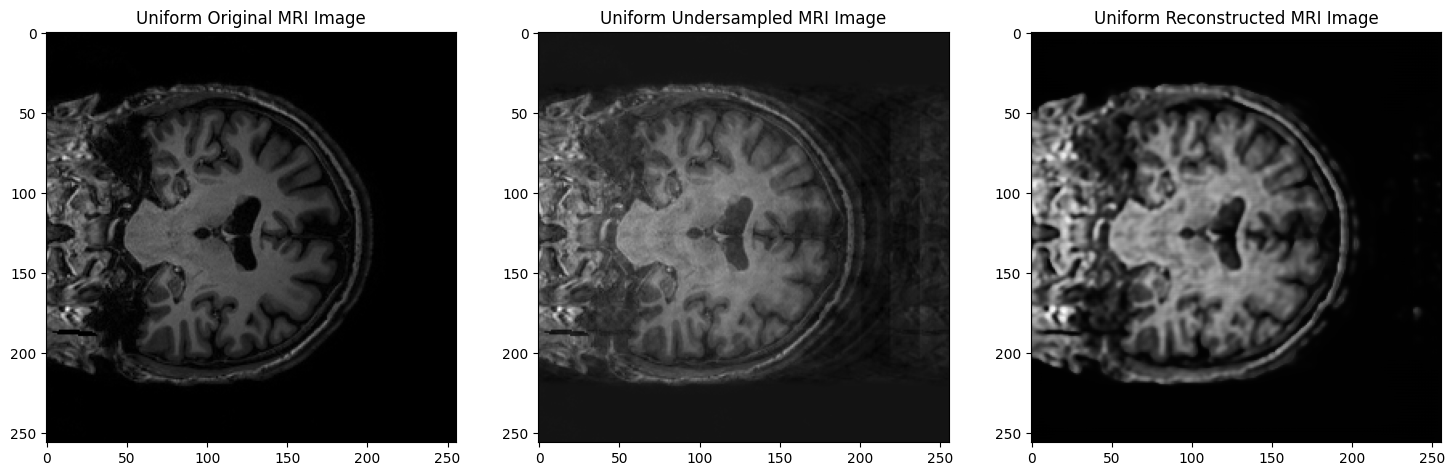

In [214]:
sample_uniform_test = next(iter(uniform_test))
display_test_image(uniform_model, sample_uniform_test, device, "Uniform")

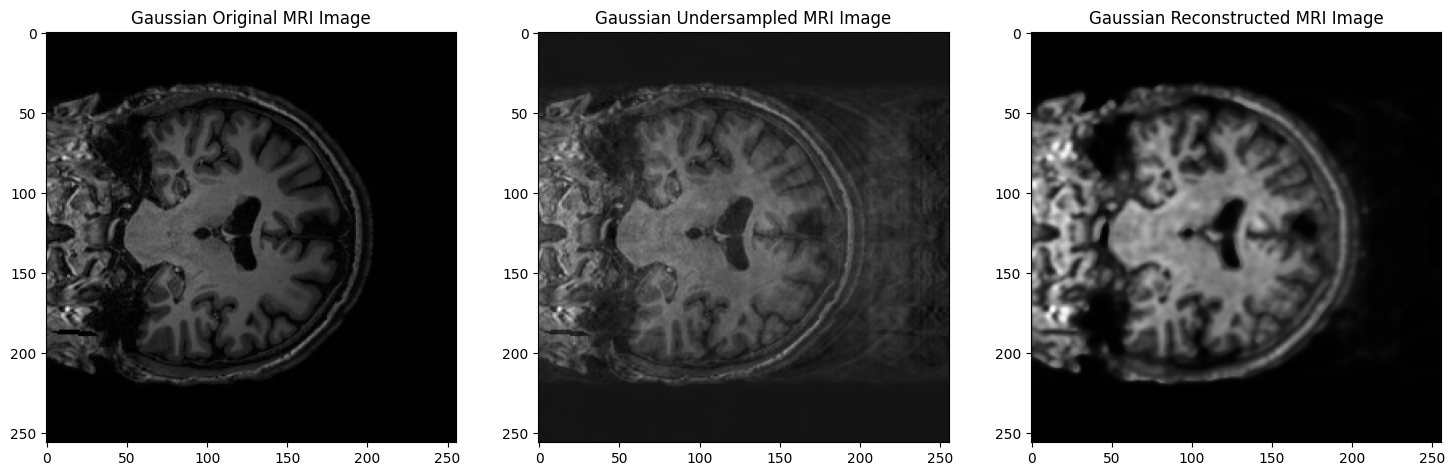

In [215]:
sample_gaussian_test = next(iter(gaussian_test))
display_test_image(gaussian_model, sample_gaussian_test, device, "Gaussian")

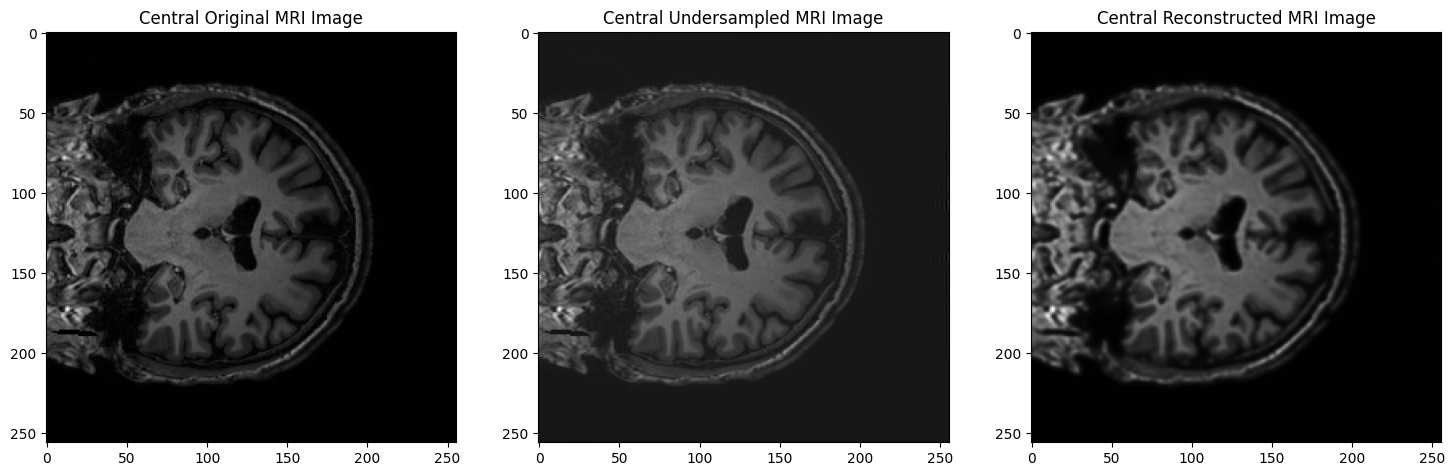

In [216]:
sample_central_test = next(iter(central_test))
display_test_image(central_model, sample_central_test, device, "Central")

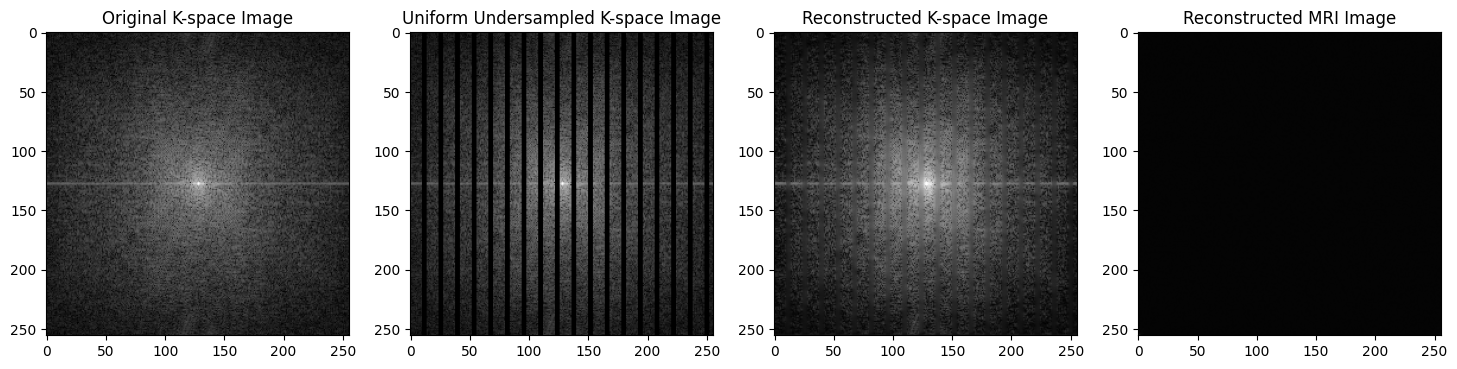

In [256]:
display_test_kspace(uniform_kspace_model, sample_uniform_test, device, "Uniform")

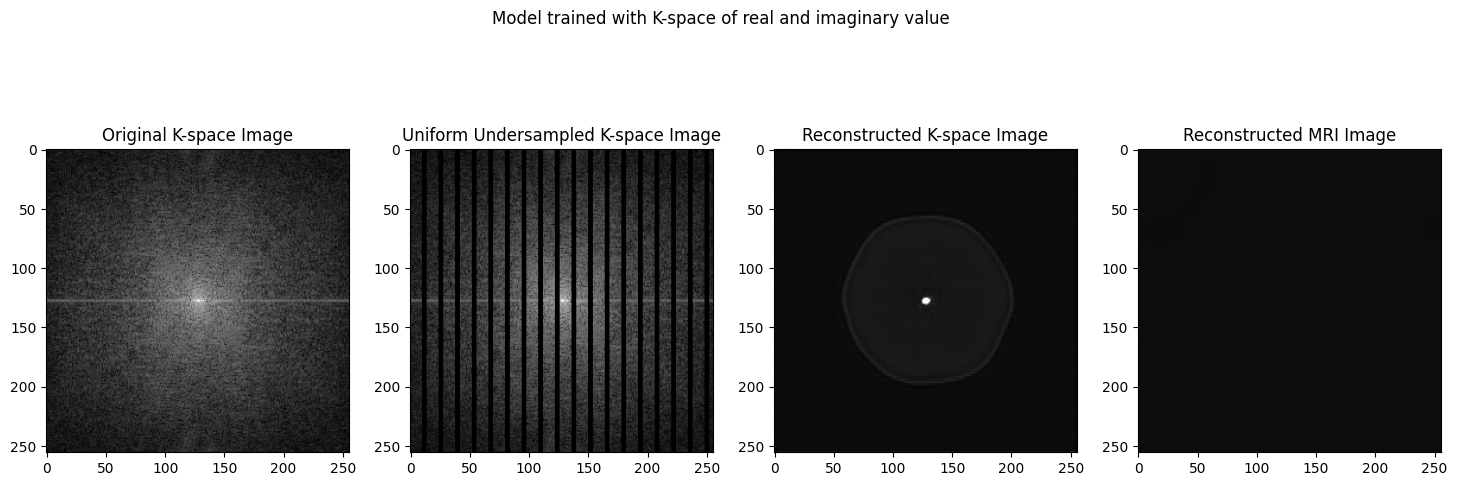

In [324]:
display_test_kspace_with_imag(uniform_kspace_model_2, sample_uniform_test, device, "Uniform")

In [286]:
testing_model = uniform_kspace_model
data = sample_uniform_test

testing_model.eval()
with torch.no_grad():
    
    inputs, targets = data['under_kspace'], data['target_kspace']
    imaginary = np.imag(inputs)[0].numpy()
    print(imaginary.shape)
    inputs = np.abs(inputs)
    inputs = np.log(inputs + 1)

    
    targets = np.abs(targets)
    print(targets.max())
    targets = np.log(targets + 1)
    print(targets.max())
    
    inputs = inputs / torch.max(inputs)
    targets = targets / torch.max(targets)
    
    inputs = inputs.unsqueeze(1).to(device)
    targets = targets.unsqueeze(1).to(device)
    outputs = testing_model(inputs)

    inputs = inputs.detach().cpu().numpy()
    outputs = outputs.detach().cpu().numpy()
    targets = targets.detach().cpu().numpy()

    outputs = np.exp(outputs)
    print(outputs.max())
    print(outputs.shape)
    a = outputs[0][0]
    print(imaginary, a)
    recon_image = np.fft.ifftshift(np.concatenate(a,imaginary))
    recon_image = np.fft.ifft2(recon_image)
    recon_image = np.real(recon_image)
    
    fig, axes = plt.subplots(1, 4, figsize=(18, 6))  # 1 row, 3 columns, figure size of 18x6 inches
    
    ax = axes[0]
    im = ax.imshow(inputs[0][0], cmap='gray')
    ax.set_title(f'K-space Output')
    fig.colorbar(im, ax=ax)
    
    ax = axes[2]
    im = ax.imshow(outputs[0][0], cmap='gray')
    ax.set_title(f'Reconstructed K-space Image')
    fig.colorbar(im, ax=ax)
    
    ax = axes[3]
    im = ax.imshow(recon_image, cmap='gray')
    ax.set_title(f'Reconstructed MRI Image')
    fig.colorbar(im, ax=ax)

(256, 256)
tensor(6193.9476, dtype=torch.float64)
tensor(8.7315, dtype=torch.float64)
2.3318203244238958
(1, 1, 256, 256)
[[ 0.00000000e+00 -6.32301667e-01  1.66430495e+00 ... -9.64517145e-01
  -1.66430495e+00  6.32301667e-01]
 [-1.46840202e+00  4.63391991e-01  1.84810991e-02 ... -8.14409784e-04
   1.21292824e+00 -4.57504290e-01]
 [-3.98237118e-02  4.02592924e-01 -1.67478236e+00 ... -9.38858901e-02
   1.84009878e-01 -1.03289260e-01]
 ...
 [-3.39492781e-02 -8.03851323e-01 -6.16993064e-01 ... -1.22009738e+00
  -1.59879244e-01  6.14502009e-01]
 [ 3.98237118e-02  1.03289260e-01 -1.84009878e-01 ...  9.57067050e-01
   1.67478236e+00 -4.02592924e-01]
 [ 1.46840202e+00  4.57504290e-01 -1.21292824e+00 ...  4.48455344e-01
  -1.84810991e-02 -4.63391991e-01]] [[1.12237851 1.09581079 1.10682971 ... 1.10034616 1.12160986 1.09908467]
 [1.10975202 1.06149322 1.05521856 ... 1.06112624 1.08725477 1.09665417]
 [1.10502726 1.06049911 1.07420899 ... 1.06089101 1.05998685 1.08656905]
 ...
 [1.07847182 1.070

TypeError: only integer scalar arrays can be converted to a scalar index